In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_theme(style="white")

COLOR_MAP = "colorblind"

sns.color_palette(COLOR_MAP)

COLORS = {
    "bigscape_blue": "#52A3A3",
    "dark_blue": "#0E75BB",
    "orange_i_found_on_bigscape_image": "#F7931E",
    "antismash_red": "#AA0000",
    "bigslice_grey": "#515154",
}

perf_colors = [
    COLORS["bigscape_blue"],
    COLORS["dark_blue"],
    COLORS["orange_i_found_on_bigscape_image"],
    COLORS["antismash_red"],
]

# make the font type editable in the svg
mpl.rcParams["svg.fonttype"] = "none"

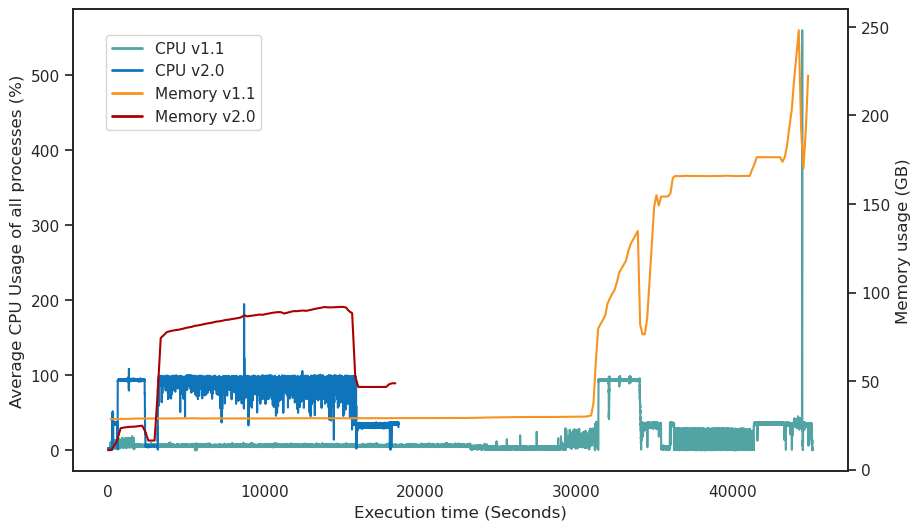

In [3]:
# load performance for single run
partition_1_perf_1k = pd.read_csv("25000_partition_1_perf.csv")

# add mean cpu usage to the dataframe
stats = partition_1_perf_1k.groupby(["seconds", "version"])[["cpu"]].mean()
# multiply by 100 to get percentage
stats["cpu"] *= 100

# load the ganglia data for memory
ganglia_memory_v1_25000 = pd.read_csv("ganglia_memory_v1_25000.csv")
ganglia_memory_v2_25000 = pd.read_csv("ganglia_memory_v2_25000.csv")

# simple line chart - cpu
fig = plt.figure(figsize=(10, 6))
sns.lineplot(data=stats[stats.index.get_level_values("version") == "v1"], x="seconds", y="cpu", linestyle="-", color=COLORS["bigscape_blue"], legend=False)
sns.lineplot(data=stats[stats.index.get_level_values("version") == "v2"], x="seconds", y="cpu", linestyle="-", color=COLORS["dark_blue"], legend=False)
plt.xlabel("Execution time (Seconds)")
plt.ylabel("Average CPU Usage of all processes (%)")


# the ganglia dataframes contain no time information. instead, we have to assume
# point 0 corresponds to first cpu timestamp and the last point to the last cpu timestamp
max_v1_time = stats[stats.index.get_level_values("version") == "v1"].index.get_level_values("seconds").max()
max_v2_time = stats[stats.index.get_level_values("version") == "v2"].index.get_level_values("seconds").max()

for i, row in ganglia_memory_v1_25000.iterrows():
    ganglia_memory_v1_25000.at[i, "seconds"] = i * max_v1_time / len(ganglia_memory_v1_25000)

for i, row in ganglia_memory_v2_25000.iterrows():
    ganglia_memory_v2_25000.at[i, "seconds"] = i * max_v2_time / len(ganglia_memory_v2_25000)


# convert bytes to gigabytes
ganglia_memory_v1_25000["Memory usage (GB)"] = ganglia_memory_v1_25000["Use\g"] / 1024 / 1024 / 1024
ganglia_memory_v2_25000["Memory usage (GB)"] = ganglia_memory_v2_25000["Use\g"] / 1024 / 1024 / 1024


ax2 = plt.twinx()
sns.lineplot(data=ganglia_memory_v1_25000, x="seconds", y="Memory usage (GB)", ax=ax2, legend=False, linestyle="-", color=COLORS["orange_i_found_on_bigscape_image"])
sns.lineplot(data=ganglia_memory_v2_25000, x="seconds", y="Memory usage (GB)", ax=ax2, legend=False, linestyle="-", color=COLORS["antismash_red"])



# create a fresh legend
text = ["CPU v1.1", "CPU v2.0", "Memory v1.1", "Memory v2.0"]

handles = [plt.Line2D([0], [0], color=perf_colors[i], linewidth=2, linestyle="-") for i in range(4)]
labels = text

legend = fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.15, 0.85))

# add legend to figure
# fig.legend(lines, text, loc='upper right')

plt.savefig("performance_one_run.svg")